# Reto: Precio por m2


# Primera parte: 

- La base inicial se transformó utiluzando PowerQuery en Excel.
- Se dividió columnas de locación para obtener tres columnas: calle, colonia y estado.
- Se eliminaron 16 columnas que repetían información para quedar con 18 columnas.
- La columna "disposition" contaba únicamente con 20 observaciones, por lo que se eliminó.
- Aun se presenta errores en las columnas de texto, caracteres especiales en nombres.


In [1]:
#Dependencias
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [ ]:
# Dependencias para modelo de regresión lineal
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

In [ ]:
import shap

In [ ]:
# Dependencias para modelo de random forest
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [ ]:
# Dependencias para SQL
import sqlalchemy as sql
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy import MetaData

In [ ]:
# AWS password
from config import key

# Cargando la base

In [2]:
reto_precios_to_load= 'C:/Users/alelo/Documents/DD360/reto_precios_v1.csv'

# Análisis Exploratorio

In [3]:
#Convirtiendo la base en Dataframe
precios_df= pd.read_csv(reto_precios_to_load)

#Primeras filas del dataframe
precios_df.head()

,street,suburb,state,vendor,lat,lon,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,department_type,m2,final_price,price_square_meter
0,Sinaloa 20,"Roma Sur, Roma Sur, Cuauhtémoc",Distrito Federal,Investemx,19.421317,-99.164182,5,3,2,0,1,0.0,2,2,apt,127.0,9000000.0,70866.14
1,Tonala,"Roma Norte, Cuauhtémoc",Distrito Federal,Avitana,19.421029,-99.163541,7,2,1,0,0,0.0,1,1,apt,54.0,4264000.0,78962.96
2,Tepeji 43,"Roma Sur, Ciudad De México, Cdmx, México, Rom...",Distrito Federal,Ebranuncios,19.407814,-99.161872,4,0,3,2,3,0.0,2,3,apt,163.0,8093500.0,49653.37
3,Linares,"Roma Sur, Cuauhtémoc",Distrito Federal,Houm,19.404992,-99.160243,150,2,2,0,0,853.0,1,2,Loft,93.0,4000000.0,43010.75
4,Frontera,"Roma Norte, Cuauhtémoc",Distrito Federal,Contactobienesraicesgold,19.419693,-99.156036,52,4,2,0,0,0.0,1,2,apt,103.0,6732700.0,65366.02


In [4]:
# Información sobre las columnas y observaciones
precios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              981 non-null    object 
 1   suburb              981 non-null    object 
 2   state               981 non-null    object 
 3   vendor              981 non-null    object 
 4   lat                 981 non-null    float64
 5   lon                 981 non-null    float64
 6   days_on_site        981 non-null    int64  
 7   amenities           981 non-null    int64  
 8   bathrooms           981 non-null    int64  
 9   cellars             981 non-null    int64  
 10  num_floors          981 non-null    int64  
 11  monthly_fee_mxn     981 non-null    float64
 12  parking_lots        981 non-null    int64  
 13  beds                981 non-null    int64  
 14  department_type     981 non-null    object 
 15  m2                  981 non-null    float64
 16  final_pr

In [5]:
# Información sobre estadísticas descriptivas
precios_df[['days_on_site', 'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price', 'price_square_meter']].describe().round(2)

,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,m2,final_price,price_square_meter
count,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00
mean,103.48,2.10,1.97,0.05,0.31,28.92,1.33,2.10,111.82,6144619.88,61049.00
std,116.79,2.23,0.89,0.23,1.30,287.13,0.48,0.63,231.60,2907088.80,19327.44
min,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,31.00,634217.00,582.25
25%,31.00,0.00,2.00,0.00,0.00,0.00,1.00,2.00,75.00,4330000.00,52294.12
50%,59.00,2.00,2.00,0.00,0.00,0.00,1.00,2.00,93.00,5511689.00,61271.47
75%,120.00,4.00,2.00,0.00,0.00,0.00,2.00,2.00,129.00,7700000.00,70175.44
max,730.00,8.00,23.00,2.00,12.00,4000.00,3.00,4.00,7210.00,22330000.00,150514.82


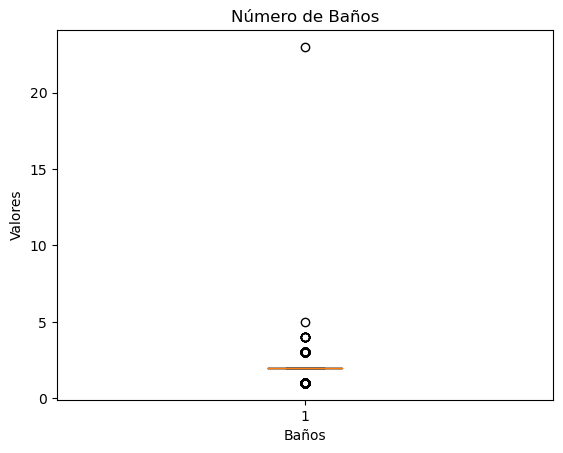

In [6]:
# box plot para número de baños, ya que el máximo es 23 y es un número ilógico para un departamento
plt.boxplot(precios_df['bathrooms'])

# Etiquetas de los ejes y título
plt.xlabel('Baños')
plt.ylabel('Valores')
plt.title('Número de Baños')

# Mostrar el box plot
plt.show()

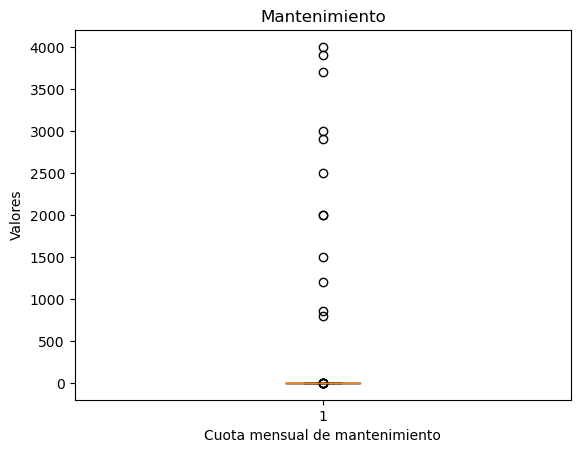

In [7]:
# Box plot para cuota mensual de mantenimiento para revisar si son outliers
plt.boxplot(precios_df['monthly_fee_mxn'])

# Etiquetas de los ejes y título
plt.xlabel('Cuota mensual de mantenimiento')
plt.ylabel('Valores')
plt.title('Mantenimiento')

# Mostrar el box plot
plt.show()

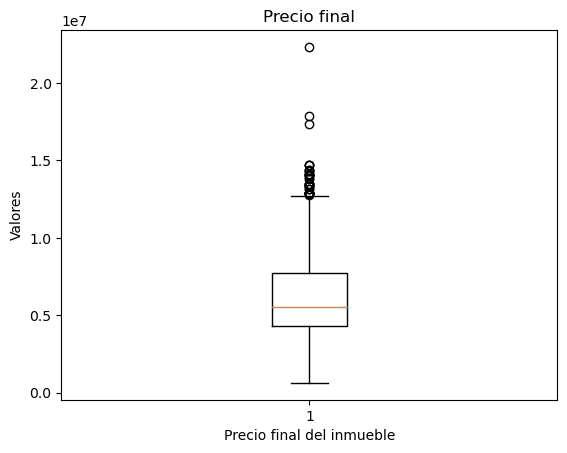

In [8]:
# Box plot para precio final
plt.boxplot(precios_df['final_price'])

# Etiquetas de los ejes y título
plt.xlabel('Precio final del inmueble')
plt.ylabel('Valores')
plt.title('Precio final')

# Mostrar el box plot
plt.show()

In [9]:
# Se tiene tres estados representados en la base de datos
len(precios_df.state.unique())

3

In [10]:
# Existen 141 compañias/empresas inmobiliarias
len(precios_df.vendor.unique())

141

In [11]:
#calles
len(precios_df.street.unique())


156

In [12]:
precios_df['street'].unique().tolist()

['Sinaloa 20 ',
 'Tonala',
 'Tepeji 43',
 'Linares',
 'Frontera',
 'Chilpancingo',
 'Roma Sur',
 'Colima',
 'Cuauhtemoc',
 'Aguascalientes',
 'Roma Norte',
 'Viaducto Miguel Alemán',
 'Querétaro',
 'Av Chapultepec',
 'Coahuila',
 'SN',
 'Alejandría 111',
 'Quintana Roo',
 'Narvarte',
 'Roma',
 'Constitucion',
 'Avenida Baja California 15',
 'Nayarit',
 'Cordoba',
 'Tonala 177 Depto 302 Ph',
 'Bajio',
 'Chiapas',
 'Sinaloa',
 'Zacatecas',
 'Tlacotalpan',
 'Tepeji',
 'Durango',
 'Salina Cruz',
 'Monterrey',
 '2 De Abril 2007',
 'Viaducto',
 'Baja California',
 'San Luis Potosi',
 'Queretaro',
 'Av. Álvaro Obregón',
 'San Luis Potosi 136',
 'Av. Chapultepec',
 'Tonalá',
 'Departamentos Nuevos Roma Norte Coahuila',
 'Tlacotalpan 89',
 'Huatabampo 30',
 'Avenida Chapultepec',
 'Córdoba 223',
 'Tonala 177 Depto 301 Ph',
 'Acayucan',
 'Venta De Departamento En Colonia Roma',
 'Guanajuato',
 'Puerto Mexico',
 'Departamentos En Preventa Av. Eugenio Garza Sada',
 'Viaducto Miguel Aleman',
 'Bají

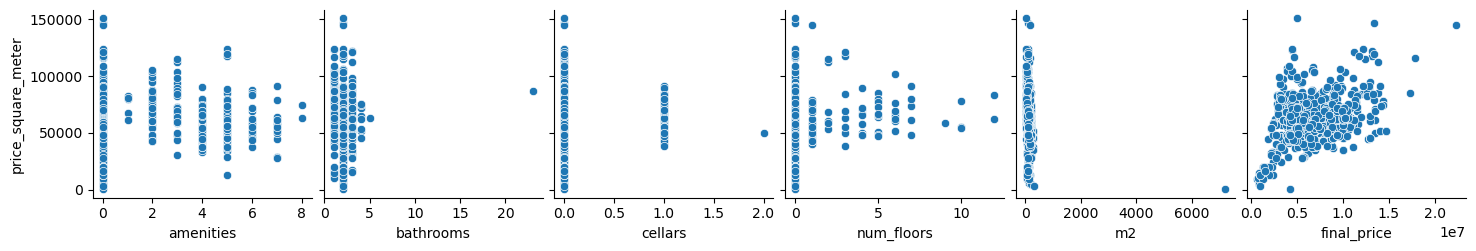

In [13]:
# Diagrama de dispersión para observar relaciones entre las variables
sns.pairplot(precios_df, x_vars=['amenities', 'bathrooms', 'cellars', 'num_floors', 'm2','final_price'], y_vars=['price_square_meter'])
plt.show()

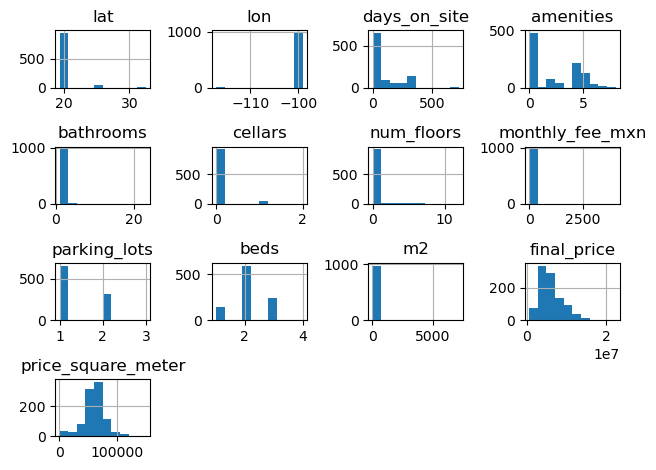

In [14]:
# Visualizando distribuciones, histogramas
precios_df.hist()
plt.tight_layout()
plt.show()

In [26]:
# DataFrame con las variables relevantes
variables = ['days_on_site', 'amenities', 'bathrooms','cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price']
precios_df2 = precios_df[['price_square_meter'] + variables]

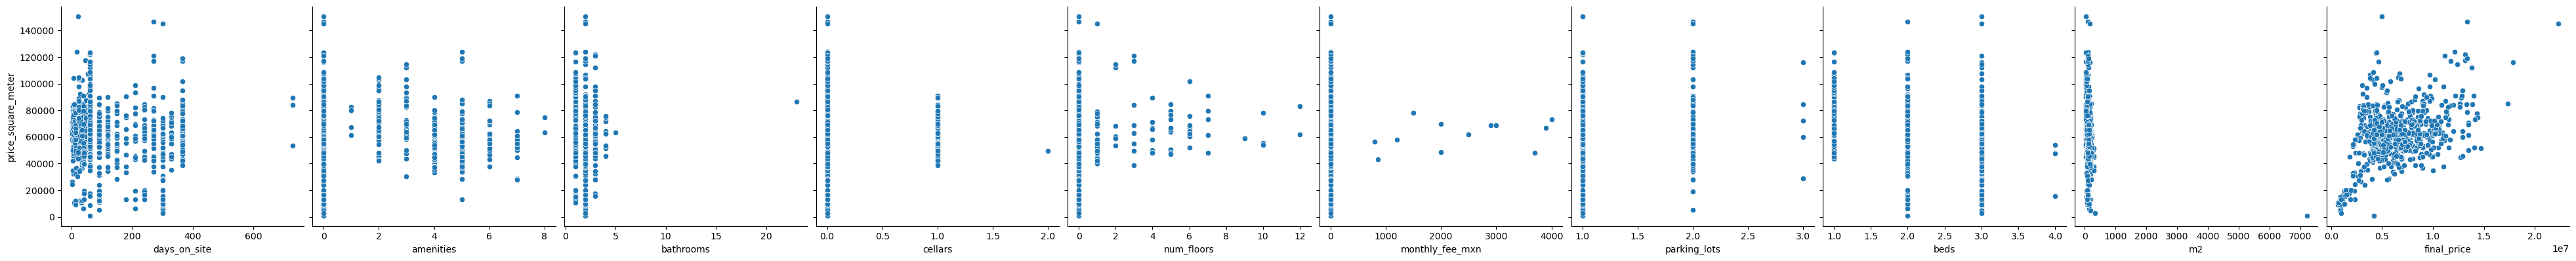

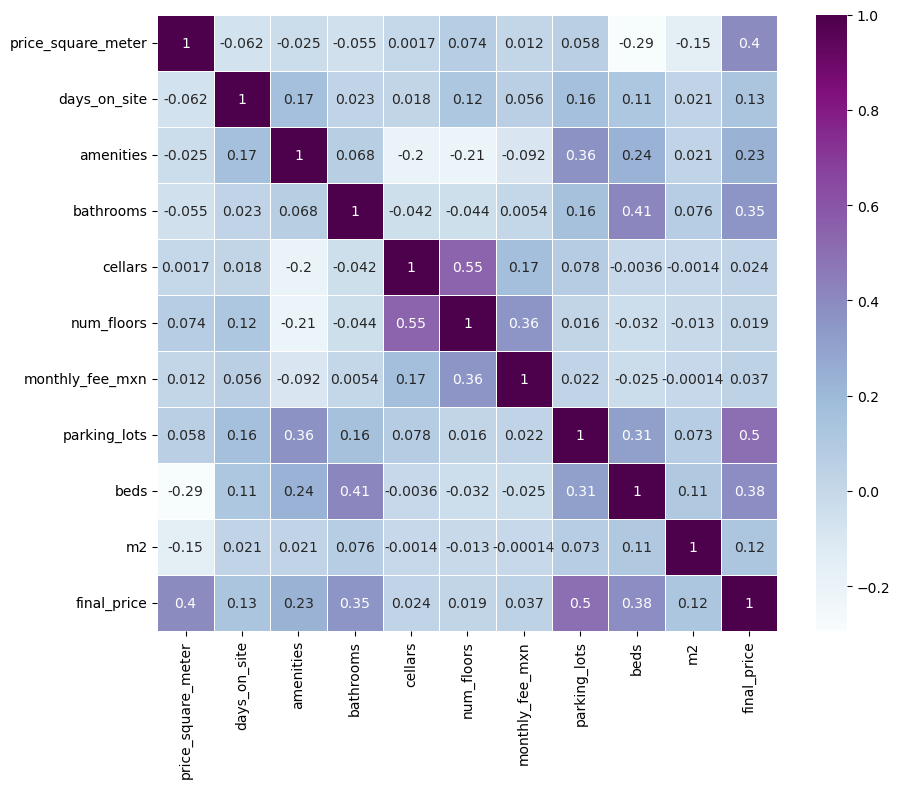

In [27]:
# Gráfico de dispersión entre "price_square_meter" y otras variables
sns.pairplot(precios_df2,x_vars=variables, y_vars='price_square_meter', kind='scatter', height=4)

# Calcular la matriz de correlación
correlation_matrix = precios_df2.corr()

# Visualizar la matriz de correlación en un mapa de calor
# https://seaborn.pydata.org/generated/seaborn.heatmap.html 
# https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, linewidth=.5, cmap='BuPu')

# Mostrar los gráficos
plt.show()

In [28]:
variables_2 = ['days_on_site', 'bathrooms', 'cellars', 'num_floors', 'parking_lots', 'm2']
precios_df3 = precios_df[['price_square_meter'] + variables_2]

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001F557A86D30> (for post_execute):


KeyboardInterrupt: 

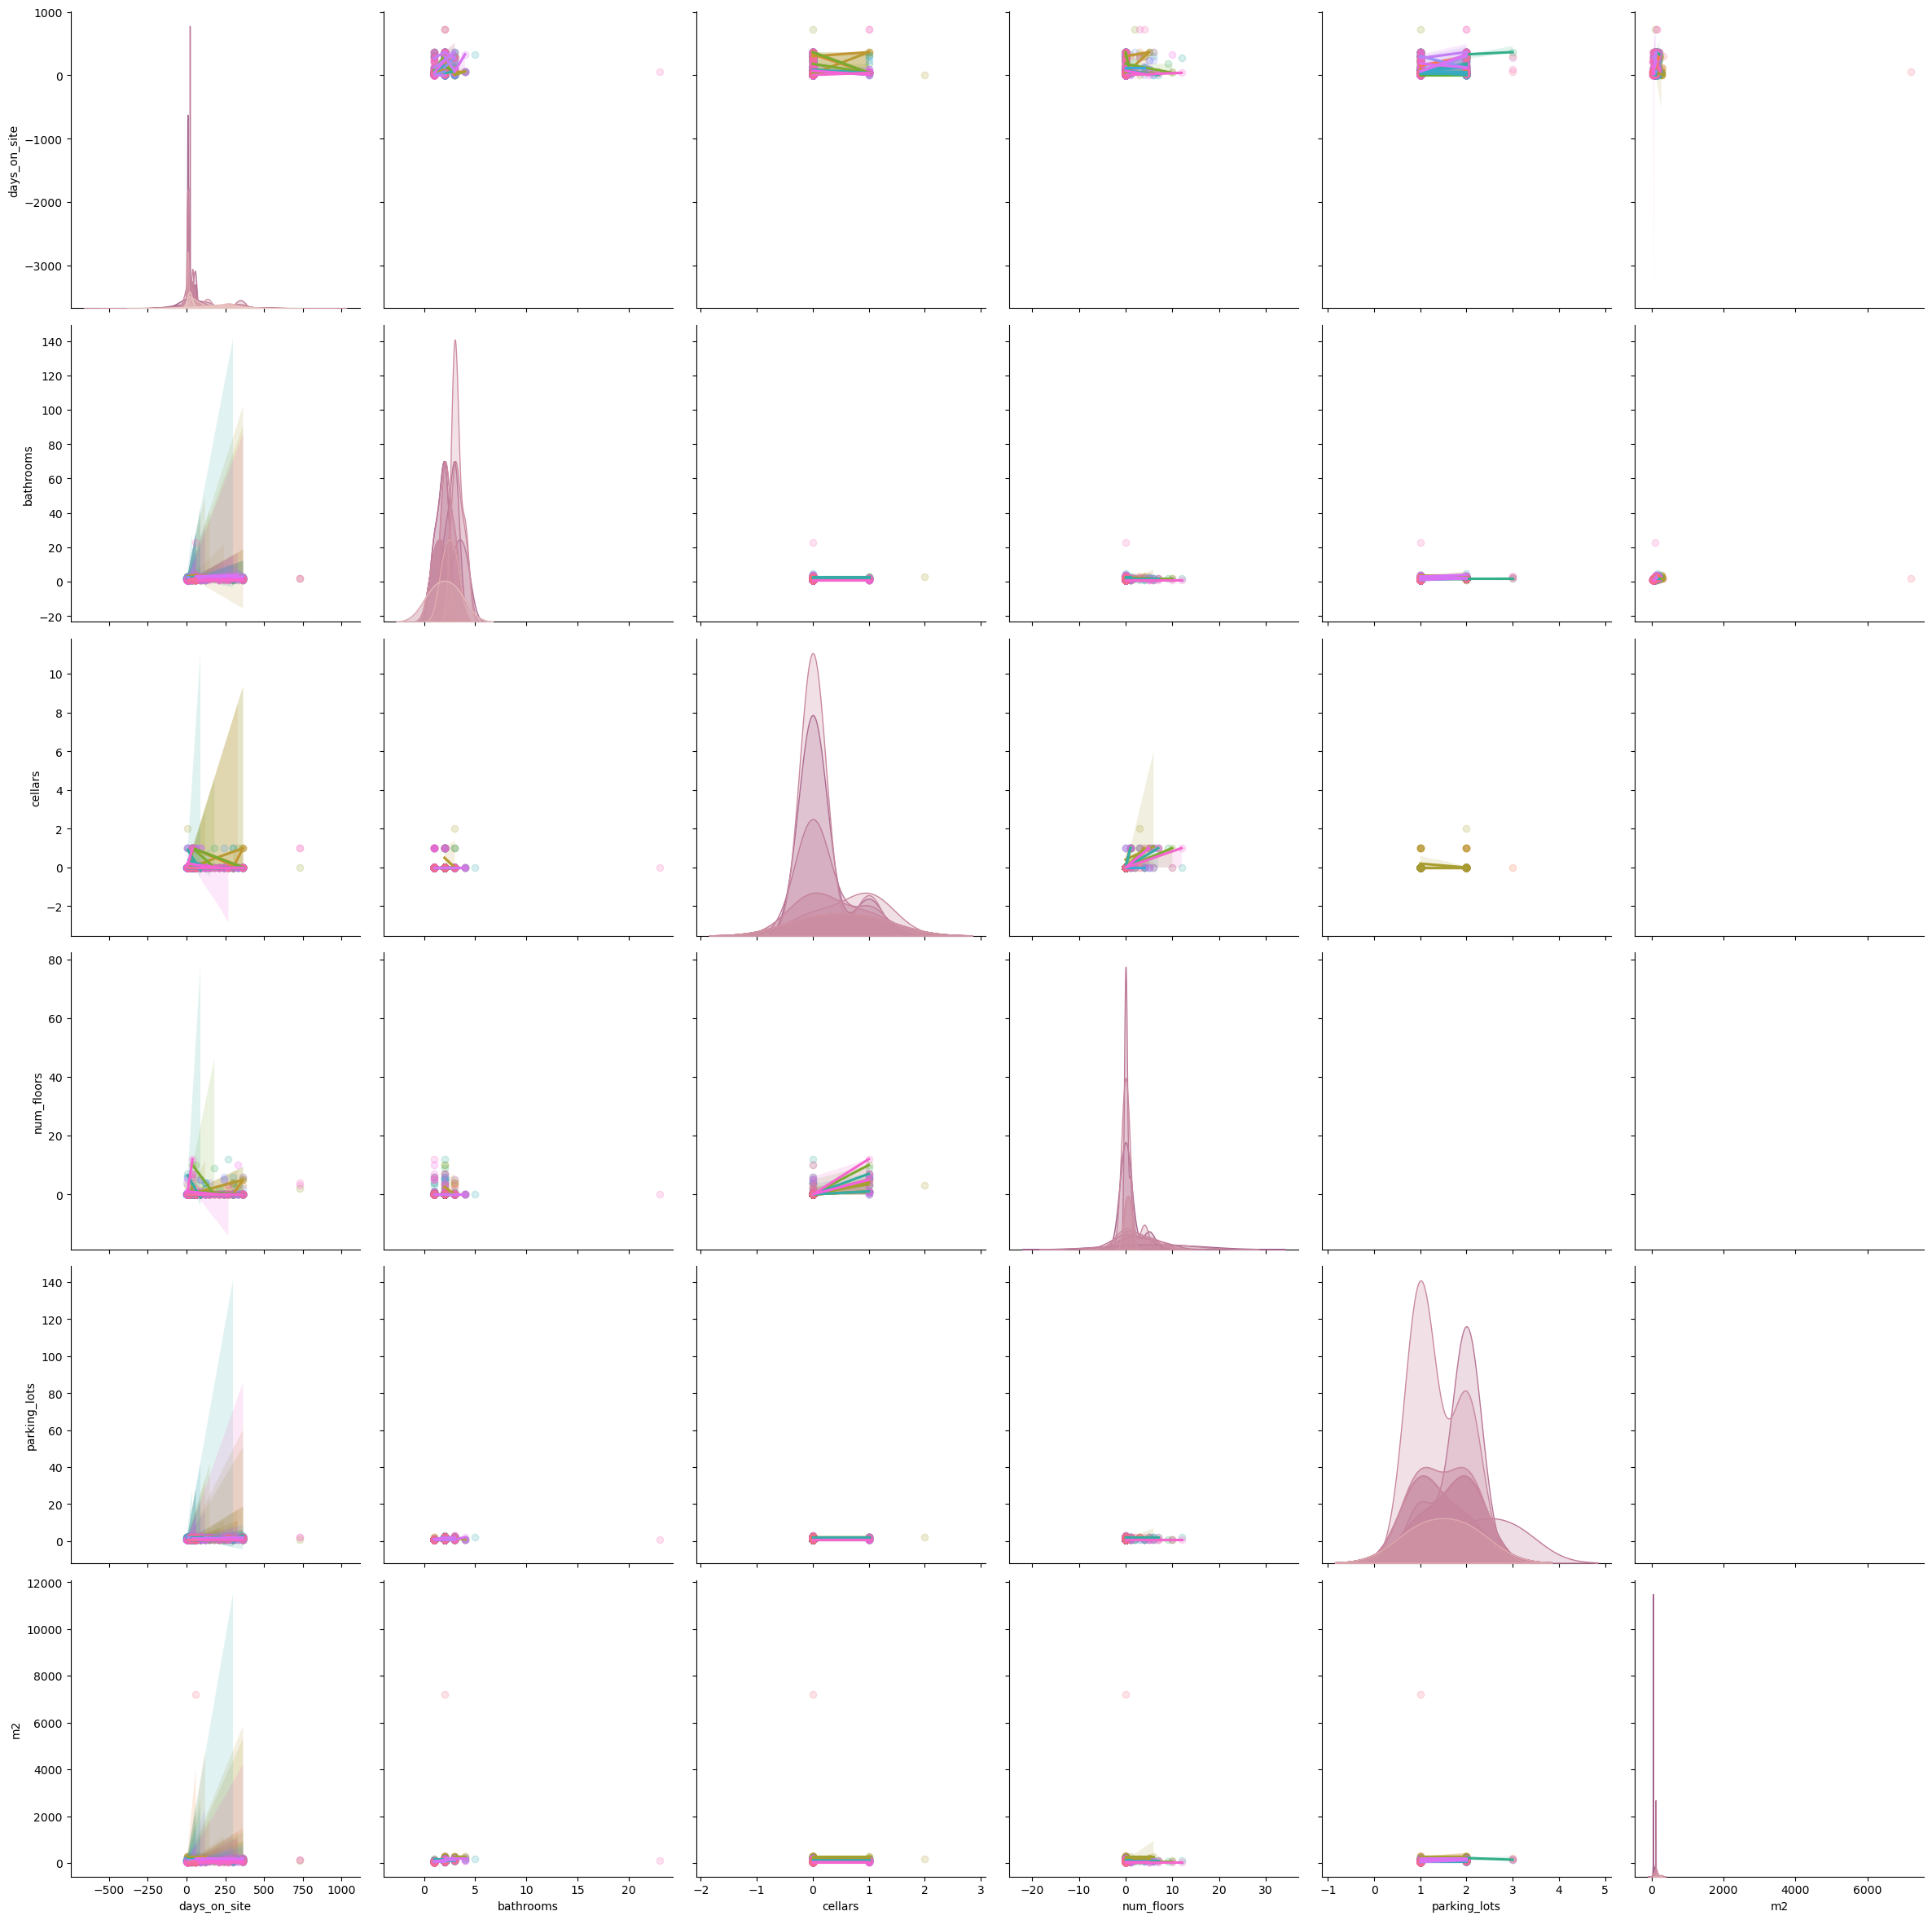

In [29]:
# Buscando posibles relaciones
# Generar el gráfico de dispersión con líneas de regresión
sns.pairplot(precios_df3, hue='price_square_meter', height=4, vars=variables_2, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.2}})

# Mostrar los gráficos
plt.show()

## Regresión Lineal